In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import cmasher as cmr
import networkx as nx
from scipy.linalg import null_space
from scipy.linalg import sqrtm
%matplotlib inline


import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

import models
from models import Renorm_Dynamic
from EI_calculation import approx_ei
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')

from thop import profile
from torch.autograd.functional import jacobian

In [2]:
def EI_calculate_pdet(A, Sigma):
    """
    Calculate the Effective Information (EI) based on the pseudo-determinant.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    float: The logarithm of the pseudo-determinant (EI).
    """
    n = A.shape[1]
    # Compute the SVD of A^T * Sigma^-1 * A, and return the product of singular values greater than 1e-10
    _, s, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    pseudo_det = np.prod(s[s > 1e-10])  # Only consider non-zero singular values
    
    # Effective Information (EI) is the log of the pseudo-determinant scaled by constants
    EI = math.log(abs(pseudo_det)**(1/2) / (2 * np.pi * np.e)**(n / 2))
    
    return EI


def EI_calculate_m_star(A, Sigma, k):
    """
    Calculate the maximum Effective Information (max EI) using the first k singular values.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    k (int): The number of singular values to consider.
    
    Returns:
    float: The logarithm of the pseudo-determinant using the top k singular values (max EI).
    """
    n = A.shape[1]
    # Compute the SVD of A^T * Sigma^-1 * A, and take the product of the first k singular values
    _, s, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    max_pseudo_det = np.prod(s[:k])
    
    # max EI is the log of the top k singular values' product, scaled by constants
    max_EI = math.log(abs(max_pseudo_det)**(1/2) / (2 * np.pi * np.e)**(k / 2))
    
    return max_EI

def Gamma(alpha, r_eps, A, Sigma):
    """
    Calculate the Gamma function based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r_eps (int): The number of singular values to consider.
    A (ndarray): Input matrix A, of size n x n.
    Sigma (ndarray): Input matrix Sigma, of size n x n.
    
    Returns:
    float: The computed Gamma value.
    """
    n = A.shape[1]
    
    # Compute the SVD of A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Compute the SVD of Sigma
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    gamma_value = (2 * np.pi / alpha)**(n / 2) * \
                  np.prod(s_AS2[:r_eps])**(1 / 2 - alpha / 4) * \
                  np.prod(s_S2[:r_eps])**(alpha / 4)
    
    return gamma_value

def gamma_0(alpha, r, A, Sigma):
    """
    Calculate gamma_0 based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r (int): The number of singular values to consider.
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    float: The computed gamma_0 value.
    """
    n = A.shape[1]
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Perform SVD on Sigma^-1
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    # Compute gamma_0 using the top r singular values
    gamma_0_value = np.sum(np.log(s_AS2[:r]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:n]))*(alpha / 4)
    
    return gamma_0_value


def gamma(alpha, r_eps, A, Sigma):
    """
    Calculate gamma based on the singular values of matrices A and Sigma.
    
    Parameters:
    alpha (float): The alpha parameter.
    r_eps (int): The number of singular values to consider.
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    float: The computed gamma value.
    """
    n = A.shape[1]
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    # Perform SVD on Sigma^-1
    _, s_S2, _ = np.linalg.svd(np.linalg.inv(Sigma))
    
    # Compute gamma using the top r_eps singular values
  
    gamma_value = np.sum(np.log(s_AS2[:r_eps]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:r_eps]))*(alpha / 4)
    
    return gamma_value


def calculate_threshold(A, Sigma):
    """
    Calculate the threshold based on the singular values of A^T * Sigma^-1 * A.
    
    Parameters:
    A (ndarray): Input matrix A, size n x n.
    Sigma (ndarray): Input covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: The threshold value and its corresponding index.
    """
    # Perform SVD on A^T * Sigma^-1 * A
    _, s_AS2, _ = np.linalg.svd(A.T @ np.linalg.inv(Sigma) @ A)
    
    # Compute the differences between consecutive singular values
    diff = np.diff(s_AS2)
    
    # Compute the ratio of consecutive singular values to avoid division by zero
    ratio = s_AS2[:-1] / s_AS2[1:]  # Element-wise division
    
    # Find the index of the maximum product of difference and ratio
    max_diff_index = np.argmax(np.abs(diff) * np.abs(ratio))
    
    # Return the threshold value and the index (index is adjusted by +1)
    return s_AS2[max_diff_index + 1], max_diff_index + 1

def clear_causal_emergence(A, Sigma):
    """
    Calculate the causal emergence based on changes in effective information (EI) and gamma values.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: Delta_J_R and Delta_Gamma_0 values representing causal emergence.
    """
    n = A.shape[1]
    
    # Calculate the rank of A^T * Sigma^-1 * A
    rk = np.linalg.matrix_rank(A.T @ np.linalg.inv(Sigma) @ A)

    # Calculate the change in effective information (Delta_J_R)
    Delta_J_R = (EI_calculate_m_star(A, Sigma, rk) / rk) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_0)
    Delta_Gamma_0 = (gamma(1, rk, A, Sigma) / rk) - (gamma_0(1, rk, A, Sigma) / n)
    
    return Delta_J_R, Delta_Gamma_0

def vague_causal_emergence(A, Sigma):
    """
    Calculate the vague causal emergence based on the threshold calculation for causal emergence.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    
    Returns:
    tuple: Delta_J and Delta_Gamma_eps values representing vague causal emergence.
    """
    n = A.shape[1]

    epsilon, rk_eps = calculate_threshold(A, Sigma)  # Get threshold epsilon and rk_eps
    
    # Calculate the change in Effective Information (Delta_J)
    Delta_J = (EI_calculate_m_star(A, Sigma, rk_eps) / rk_eps) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_eps)
    Delta_Gamma_eps = (gamma(1, rk_eps, A, Sigma) / rk_eps) - (gamma(1, n, A, Sigma) / n)
    
    return Delta_J, Delta_Gamma_eps


def vague_causal_emergence_customize(A, Sigma, rk_eps):
    """
    Calculate the customized vague causal emergence based on a given rk_eps.
    
    Parameters:
    A (ndarray): The matrix A, size n x n.
    Sigma (ndarray): The covariance matrix Sigma, size n x n.
    rk_eps (int): The rank parameter for customized calculation.
    
    Returns:
    tuple: Delta_J and Delta_Gamma_eps values representing customized vague causal emergence.
    """
    n = A.shape[0]

    # Calculate the change in Effective Information (Delta_J)
    Delta_J = (EI_calculate_m_star(A, Sigma, rk_eps) / rk_eps) - (EI_calculate_pdet(A, Sigma) / n)
    
    # Calculate the change in gamma values (Delta_Gamma_eps)
    Delta_Gamma_eps = (gamma(1, rk_eps, A, Sigma) / rk_eps) - (gamma(1, n, A, Sigma) / n)
    
    return Delta_J, Delta_Gamma_eps

In [3]:
U = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
               [0, 1, 0, 0, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0],
               [0, 0, 0, 0, 1/np.sqrt(2), 1/np.sqrt(2), 0, 0],
               [0, 0, 0, 0, -1/np.sqrt(2), 1/np.sqrt(2), 0, 0],
               [0, 0, 0, 0, 0, 0, 1/np.sqrt(2), 1/np.sqrt(2)],
               [0, 0, 0, 0, 0, 0, -1/np.sqrt(2), 1/np.sqrt(2)]])

In [4]:
V = np.array([[0,0,0,0,1/np.sqrt(2),0,0,1/np.sqrt(2)],
              [0,1/np.sqrt(2),1/np.sqrt(2),0,0,0,0,0],
              [0,-1/np.sqrt(2),1/np.sqrt(2),0,0,0,0,0],
              [0,0,0,0,-1/np.sqrt(2),0,0,1/np.sqrt(2)],
              [1,0,0,0,0,0,0,0],
              [0,0,0,0,0,1,0,0],
              [0,0,0,0,0,0,1,0],
              [0,0,0,1,0,0,0,0]])

In [5]:
U1 = U[:,:4]
U2 = U[:,4:]
V1 = V[:,:4]
V2 = V[:,4:]

In [6]:
U[:,2]@V2,U[:,1]@V2,V[:,2]@U2,V[:,1]@U2

(array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]))

In [7]:
AB = null_space(np.hstack((U1, -V1)))

In [8]:
a = AB[:4,:]
b = AB[4:,:]

In [9]:
a*np.sqrt(2),b*np.sqrt(2)

(array([[ 0.,  0.],
        [ 0., -1.],
        [ 1.,  0.],
        [ 0.,  0.]]),
 array([[ 0.        ,  0.        ],
        [-0.70710678, -0.70710678],
        [ 0.70710678, -0.70710678],
        [ 0.        ,  0.        ]]))

In [10]:
U1@a*np.sqrt(2),V1@b*np.sqrt(2)

(array([[ 0.,  0.],
        [ 0., -1.],
        [ 1.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]]),
 array([[ 0.00000000e+00,  0.00000000e+00],
        [ 1.57009246e-16, -1.00000000e+00],
        [ 1.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]]))

In [11]:
S=np.diag([2,1.5,1.3,1.01,0.2,0.12,0.1,0.05])
K=np.diag([1.6,1.25,1.1,1.05,0.5,0.4,0.25,0.1])

In [12]:
AinvSigmaA = U@S@U.T
invSigma = V@K@V.T

In [13]:
AinvSigmaA

array([[ 2.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.5  ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  1.3  ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.01 ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.16 , -0.04 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.04 ,  0.16 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.075, -0.025],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.025,  0.075]])

In [14]:
invSigma

array([[ 0.3  ,  0.   ,  0.   , -0.2  ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.175, -0.075,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.075,  1.175,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.2  ,  0.   ,  0.   ,  0.3  ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  1.6  ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.4  ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.25 ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.05 ]])

In [15]:
L = np.linalg.cholesky(invSigma)
    
# Step 2: Solve X^T X = C by Cholesky decomposition
# We need to solve X = Cholesky(C) because C = X^T X
X = np.linalg.cholesky(AinvSigmaA)

# Step 3: Compute A by A = (L^T)^(-1) X
A = np.linalg.inv(L.T).dot(X)

In [16]:
A

array([[ 2.5819889 ,  0.        ,  0.        ,  1.64113782,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.12986537,  0.06727639,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.05399672,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.46170673,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.31622777,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.15811388,
         0.61237244,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.54772256,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.08908708,  0.25197632]])

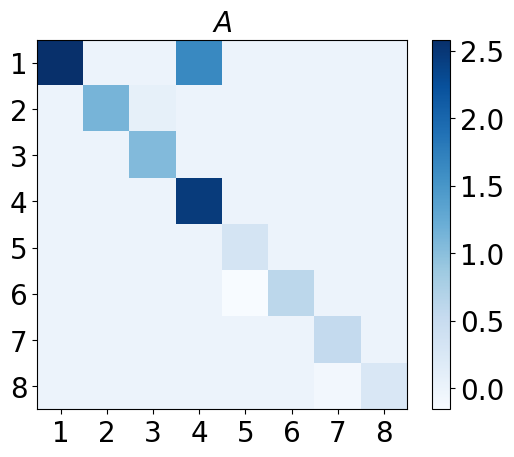

In [17]:
plt.imshow(A,cmap = "Blues")
plt.title('$A$',fontsize=20)
#c=plt.colorbar(plt.imshow(A@np.linalg.inv(A.T@np.linalg.inv(Sigma)@A)),cmap = "cmr.freeze",label='$A^T\Sigma^{-1}A$')
plt.xticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.yticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.colorbar().ax.tick_params(labelsize=20)
plt.savefig('./Figure/Random_matrix_A.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

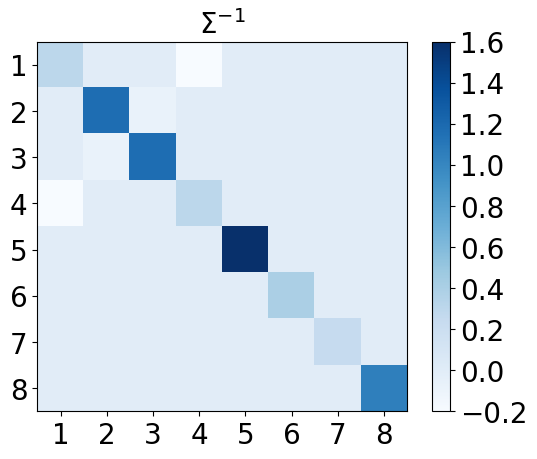

In [18]:
plt.imshow(invSigma,cmap = "Blues")
plt.title('$\Sigma^{-1}$',fontsize=20)
#c=plt.colorbar(plt.imshow(A@np.linalg.inv(A.T@np.linalg.inv(Sigma)@A)),cmap = "cmr.freeze",label='$A^T\Sigma^{-1}A$')
plt.xticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.yticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.colorbar().ax.tick_params(labelsize=20)
plt.savefig('./Figure/Random_matrix_invSigma.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

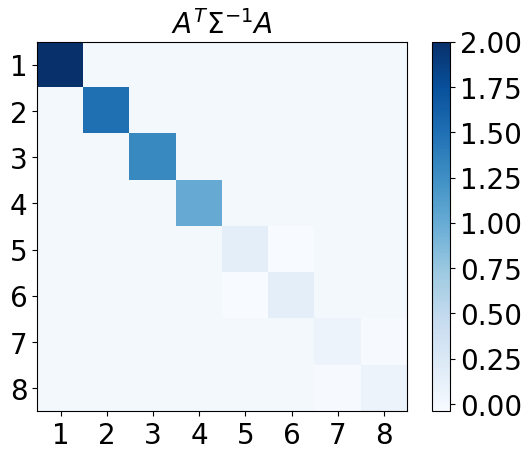

In [19]:
plt.imshow(AinvSigmaA,cmap = "Blues")
plt.title('$A^T\Sigma^{-1}A$',fontsize=20)
#c=plt.colorbar(plt.imshow(A@np.linalg.inv(A.T@np.linalg.inv(Sigma)@A)),cmap = "cmr.freeze",label='$A^T\Sigma^{-1}A$')
plt.xticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.yticks(np.arange(8), np.arange(1, 9),fontsize=20)
plt.colorbar().ax.tick_params(labelsize=20)
plt.savefig('./Figure/Random_matrix_ASA.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

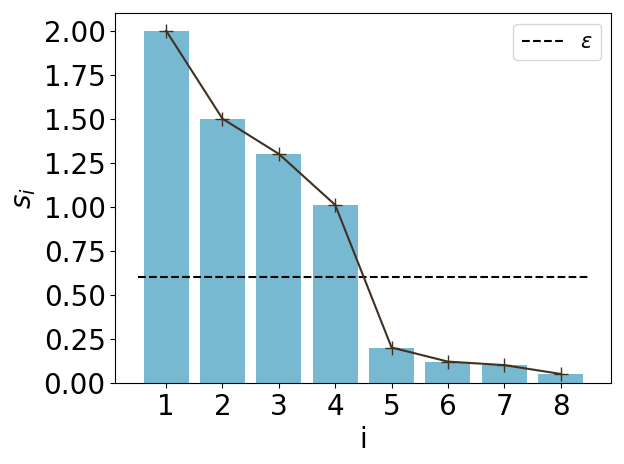

In [20]:
colors = ['#8386A8','#D15C6B','#F5CF36','#8FB943','#78B9D2','#413123']

plt.bar([1,2,3,4,5,6,7,8],np.diag(S),color = colors[4])
plt.plot([1,2,3,4,5,6,7,8],np.diag(S),color = colors[5],marker ='+',markersize =10)
plt.xlabel('i',fontsize=20)
plt.ylabel('$s_{i}$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.hlines(0.6,0.5,8.5,linestyles='--',label='$\epsilon$')
plt.legend(fontsize=15)
plt.savefig('./Figure/Random_SVD_s.png', dpi=600, format='png',bbox_inches = 'tight')

plt.show()
plt.close()

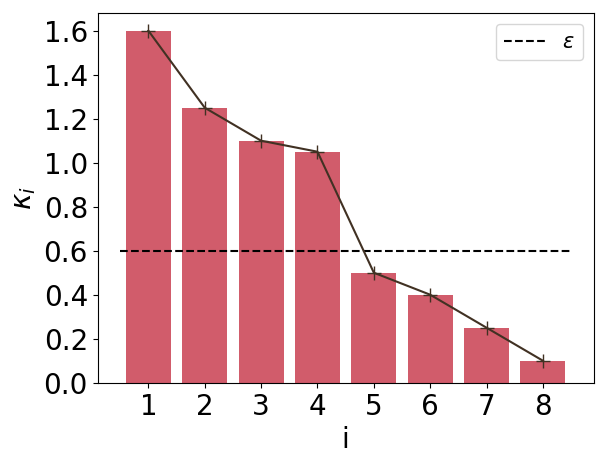

In [21]:
colors = ['#8386A8','#D15C6B','#F5CF36','#8FB943','#78B9D2','#413123']

plt.bar([1,2,3,4,5,6,7,8],np.diag(K),color = colors[1])
plt.plot([1,2,3,4,5,6,7,8],np.diag(K),color = colors[5],marker ='+',markersize =10)
plt.xlabel('i',fontsize=20)
plt.ylabel('$\kappa_i}$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.hlines(0.6,0.5,8.5,linestyles='--',label='$\epsilon$')
plt.legend(fontsize=15)
plt.savefig('./Figure/Random_SVD_kappa.png', dpi=600, format='png',bbox_inches = 'tight')

plt.show()
plt.close()

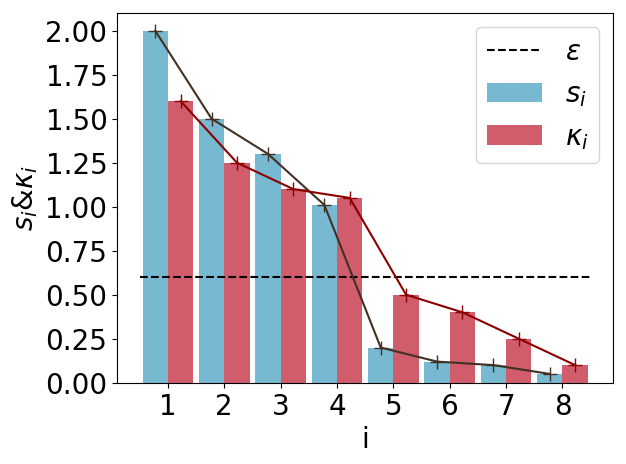

In [22]:
colors = ['#8386A8','#D15C6B','#F5CF36','#8FB943','#78B9D2','#413123']
width = 0.45
plt.bar(np.array([1,2,3,4,5,6,7,8])-width/2,np.diag(S), width,color = colors[4],label='$s_i$')
plt.plot(np.array([1,2,3,4,5,6,7,8])-width/2,np.diag(S), color = colors[5],marker ='+',markersize =10)
plt.bar(np.array([1,2,3,4,5,6,7,8])+width/2,np.diag(K), width,color = colors[1],label='$\kappa_i$')
plt.plot(np.array([1,2,3,4,5,6,7,8])+width/2,np.diag(K), color = 'darkred',marker ='+',markersize =10)
plt.xlabel('i',fontsize=20)
plt.ylabel('$s_{i}&\kappa_i$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.hlines(0.6,0.5,8.5,linestyles='--',label='$\epsilon$')
plt.legend(fontsize=20)
plt.savefig('./Figure/Random_SVD.png', dpi=600, format='png',bbox_inches = 'tight')

plt.show()
plt.close()

In [23]:
sqrtm(np.linalg.inv(invSigma))

array([[2.28824561, 0.        , 0.        , 0.87403205, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.92394489, 0.0295177 , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.0295177 , 0.92394489, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.87403205, 0.        , 0.        , 2.28824561, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.79056942,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.58113883, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 2.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.97590007]])

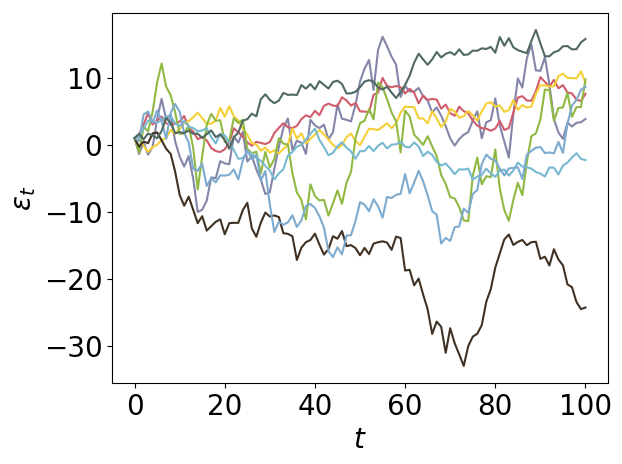

In [24]:
n = 8
T = 100

Sigma = np.linalg.inv(invSigma)

X=np.zeros([n,T+1])
e=np.zeros([n,T+1])
X[:,0]=1
for t in range(1,T+1):
    e[:,t]=np.random.multivariate_normal(np.zeros(Sigma.shape[0]),Sigma,1)
    X[:,t]=X[:,t-1]+e[:,t]

colors = ['#8386A8','#D15C6B','#F5CF36','#8FB943','#78B9D2','#413123','#7DABCF','#4F6962']
for i in range(n):
    plt.plot(range(T+1),X[i,:],label='$x_%s$'%(i+1),color=colors[i])
#plt.legend(fontsize=13)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$t$',fontsize=20)
plt.ylabel('$\\varepsilon_t$',fontsize=20)
plt.savefig('./Figure/Random.png', dpi=600, format='png',bbox_inches = 'tight')

In [25]:
W = np.hstack((abs(U1@a*np.sqrt(2)), U[:,0:1], V[:,0:1])).T

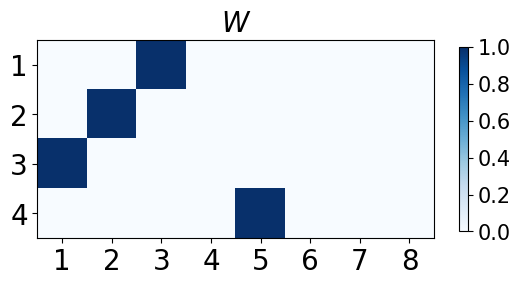

In [26]:
plt.imshow(abs(W),cmap = "Blues")
plt.title('$W$',fontsize=20)
#c=plt.colorbar(plt.imshow(A@np.linalg.inv(A.T@np.linalg.inv(Sigma)@A)),cmap = "cmr.freeze",label='$A^T\Sigma^{-1}A$')
plt.xticks(np.arange(8), np.arange(1, 9),fontsize = 20)
plt.yticks(np.arange(4), np.arange(1, 5),fontsize = 20)
plt.colorbar(shrink=0.5).ax.tick_params(labelsize=15)
plt.savefig('./Figure/W_Random.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

In [27]:
rk = 4
gamma(1,rk,A,Sigma)/rk-gamma(1,n,A,Sigma)/n

0.516703455945398

In [28]:
Sigma = np.linalg.inv(invSigma)
A_M = W@A@W.T
Sigma_M = W@Sigma@W.T
gamma(1,rk,A_M,Sigma_M)/rk-gamma(1,n,A,Sigma)/n

0.2497742001390803

In [29]:
alpha = 1
_, s_AS2, _ = np.linalg.svd(W@AinvSigmaA@W.T)
_, s_S2, _ = np.linalg.svd(W@invSigma@W.T)
r_eps = 2
gamma_value = np.sum(np.log(s_AS2[:r_eps]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:r_eps]))*(alpha / 4)
gamma_value/4 - gamma(1,n,A,Sigma)/n

0.49067752223949707

In [30]:
alpha = 1
_, s_AS2, _ = np.linalg.svd(U1.T@AinvSigmaA@U1)
_, s_S2, _ = np.linalg.svd(U1.T@invSigma@U1)
r_eps = 2
gamma_value = np.sum(np.log(s_AS2[:r_eps]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:r_eps]))*(alpha / 4)
gamma_value/4 - gamma(1,n,A,Sigma)/n

0.4672591816494089

In [31]:
alpha = 1
_, s_AS2, _ = np.linalg.svd(V1.T@AinvSigmaA@V1)
_, s_S2, _ = np.linalg.svd(V1.T@invSigma@V1)
r_eps = 2
gamma_value = np.sum(np.log(s_AS2[:r_eps]))*(1 / 2 - alpha / 4) + np.sum(np.log(s_S2[:r_eps]))*(alpha / 4)
gamma_value/4 - gamma(1,n,A,Sigma)/n

0.4637535899837187

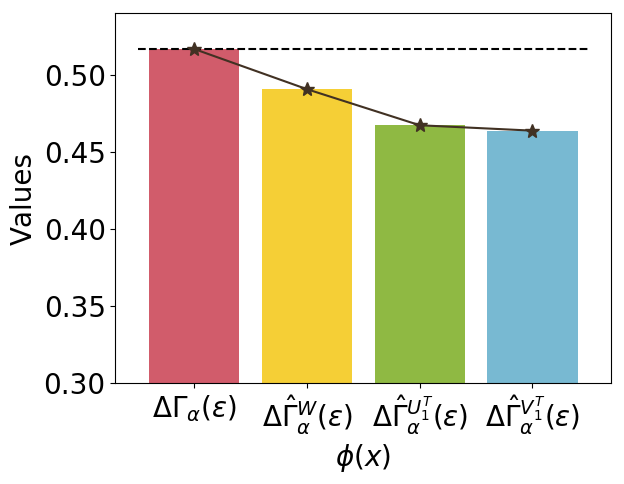

In [36]:
gammavalue = [0.5167,0.4906,0.4672,0.4637]
colors = ['#D15C6B','#F5CF36','#8FB943','#78B9D2','#413123','#7DABCF','#4F6962']
#labels = ['a','b','c','d']
plt.bar(['$\Delta\Gamma_\\alpha(\epsilon)$','$\Delta\hat{\Gamma}^W_\\alpha(\epsilon)$','$\Delta\hat{\Gamma}^{U_1^T}_\\alpha(\epsilon)$','$\Delta\hat{\Gamma}^{V_1^T}_\\alpha(\epsilon)$'], gammavalue, color=colors)
plt.plot(['$\Delta\Gamma_\\alpha(\epsilon)$','$\Delta\hat{\Gamma}^W_\\alpha(\epsilon)$','$\Delta\hat{\Gamma}^{U_1^T}_\\alpha(\epsilon)$','$\Delta\hat{\Gamma}^{V_1^T}_\\alpha(\epsilon)$'],gammavalue,color = colors[4],marker ='*',markersize =10)
plt.ylim(0.3,0.54)
plt.hlines(0.5167,-0.5,3.5,linestyles='--')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$\phi(x)$',fontsize=20)
plt.ylabel('Values',fontsize=20)
plt.savefig('./Figure/Random_Gamma_W.png', dpi=600, format='png',bbox_inches = 'tight')

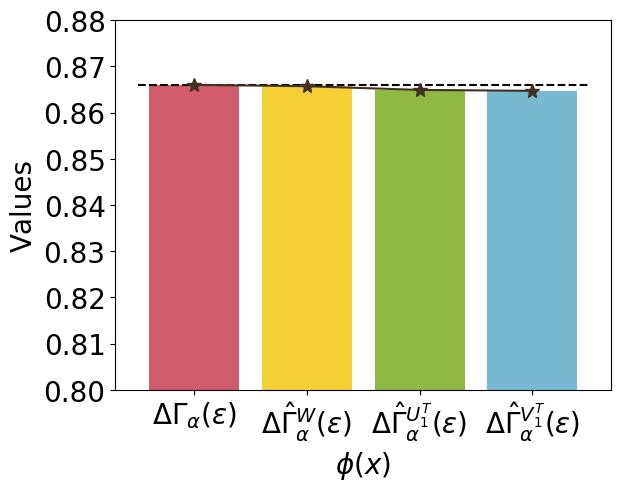

In [11]:
gammavalue = [0.8660,0.8657,0.8649,0.8647]
colors = ['#D15C6B','#F5CF36','#8FB943','#78B9D2','#413123','#7DABCF','#4F6962']
#labels = ['a','b','c','d']
plt.bar(['$\Delta\Gamma_\\alpha(\epsilon)$','$\Delta\hat{\Gamma}^W_\\alpha(\epsilon)$','$\Delta\hat{\Gamma}^{U_1^T}_\\alpha(\epsilon)$','$\Delta\hat{\Gamma}^{V_1^T}_\\alpha(\epsilon)$'], gammavalue, color=colors)
plt.plot(['$\Delta\Gamma_\\alpha(\epsilon)$','$\Delta\hat{\Gamma}^W_\\alpha(\epsilon)$','$\Delta\hat{\Gamma}^{U_1^T}_\\alpha(\epsilon)$','$\Delta\hat{\Gamma}^{V_1^T}_\\alpha(\epsilon)$'],gammavalue,color = colors[4],marker ='*',markersize =10)
plt.ylim(0.8,0.88)
plt.hlines(0.8660,-0.5,3.5,linestyles='--')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$\phi(x)$',fontsize=20)
plt.ylabel('Values',fontsize=20)
plt.savefig('./Figure/SIR_Gamma_W.png', dpi=600, format='png',bbox_inches = 'tight')